## Задание 1. 
## Определить максимальное количество людей, одновременно находившихся в системе.
Показать код и прокомментировать ход решения.
исходные данные test1.xlsx

### Решение

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Загоним исходные данные в датасет для последующих манипуляций:

In [3]:
df = pd.read_excel('test1.xlsx')

#### Подготовка датасета

Оценим датасет

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4174 entries, 0 to 4173
Data columns (total 3 columns):
Имя пользователя    4174 non-null object
Время входа         4174 non-null datetime64[ns]
Время выхода        4171 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 97.9+ KB


Для удобства, поменяем названия признаков

In [5]:
df.rename(
    columns={
        'Имя пользователя': 'username',
        'Время входа': 'login_dt',
        'Время выхода': 'logout_dt'
    }, 
    inplace=True)

In [6]:
df.head(1)

,username,login_dt,logout_dt
0,t.silaeva,2013-11-01 10:03:49,2013-11-01 10:48:48


Приведем признак __Время выхода__ к типу `datetime`

In [7]:
df['logout_dt'] = pd.to_datetime(df['logout_dt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4174 entries, 0 to 4173
Data columns (total 3 columns):
username     4174 non-null object
login_dt     4174 non-null datetime64[ns]
logout_dt    4170 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 97.9+ KB


Проверим строки с пустыми признаками

In [9]:
df[df['logout_dt'].isnull()]

,username,login_dt,logout_dt
4162,stepanov_oper,2014-02-19 12:12:36,NaT
4171,savenkov,2014-02-19 13:52:35,NaT
4172,p.sharobarov,2014-02-19 14:17:35,NaT
4173,y.dishel,2014-02-19 14:32:35,NaT


In [10]:
df.describe()

,username,login_dt,logout_dt
count,4174,4174,4170
unique,172,3650,3162
top,savenkov,2013-12-06 09:34:20,2013-11-21 17:03:03
freq,310,3,13
first,NaN,2013-11-01 10:03:49,2013-11-01 10:48:48
last,NaN,2014-02-19 14:32:35,2014-02-19 14:22:35


Поскольку последняя дата входа пользователей `2014-02-19 14:32:35` то можно предположить, что пользователи без даты выхода еще находятся в системе. Пропишем им последнюю дату входа + 5 секунд

In [11]:
last_login = df['login_dt'].max()
last_login +=  pd.to_timedelta(5, unit='s')
last_login

Timestamp('2014-02-19 14:32:40')

In [12]:
df.fillna(last_login, axis=1, inplace=True)

Далее, заменим имена пользователей на уникальные id чтобы легко по ним проходиться

In [13]:
unique_logins = pd.unique(df.username)
unique_logins = pd.Series(np.arange(len(unique_logins)), 
                          unique_logins)

df['user_id'] = df.applymap(unique_logins.get)['username']

In [14]:
df.sample(n=5)

,username,login_dt,logout_dt,user_id
131,y.dishel_oiv,2013-11-14 16:52:29,2013-11-14 17:57:28,18
35,d.tarasow,2013-11-06 10:48:54,2013-11-06 12:33:56,13
3396,a.tribunskiy,2014-01-29 10:56:08,2014-01-29 11:26:08,117
1732,m.medvedeva,2013-12-11 11:49:26,2013-12-11 12:39:28,44
630,i.golovachev,2013-11-27 11:02:50,2013-11-27 11:42:51,42


Еще раз проверим датасет

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4174 entries, 0 to 4173
Data columns (total 4 columns):
username     4174 non-null object
login_dt     4174 non-null datetime64[ns]
logout_dt    4174 non-null datetime64[ns]
user_id      4174 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 130.5+ KB


####  Алгоритм 

Создадим временной ряд от первой даты входа до последней даты выхода. По этому временному ряду будем итерироваться.

In [91]:
dt_min = df['login_dt'].min()
dt_max = df['logout_dt'].max()

# Установим шаг временного ряда в минутах
timestep = np.arange(np.datetime64(dt_min), 
                    np.datetime64(dt_max), dtype='datetime64[m]')

In [80]:
len(timestep)

158669

Процесс вычисления не быстрый, и в зависимости от точности шага (час, минута, секунда) занимает кратное время

In [81]:
ans = [sum(df['login_dt'].le(step) & df['logout_dt'].ge(step)) for step in timestep]
max(ans)

37

Мы получили ответ что максимальное количество онлайн-пользователей - __37__

#### Визуализация результата

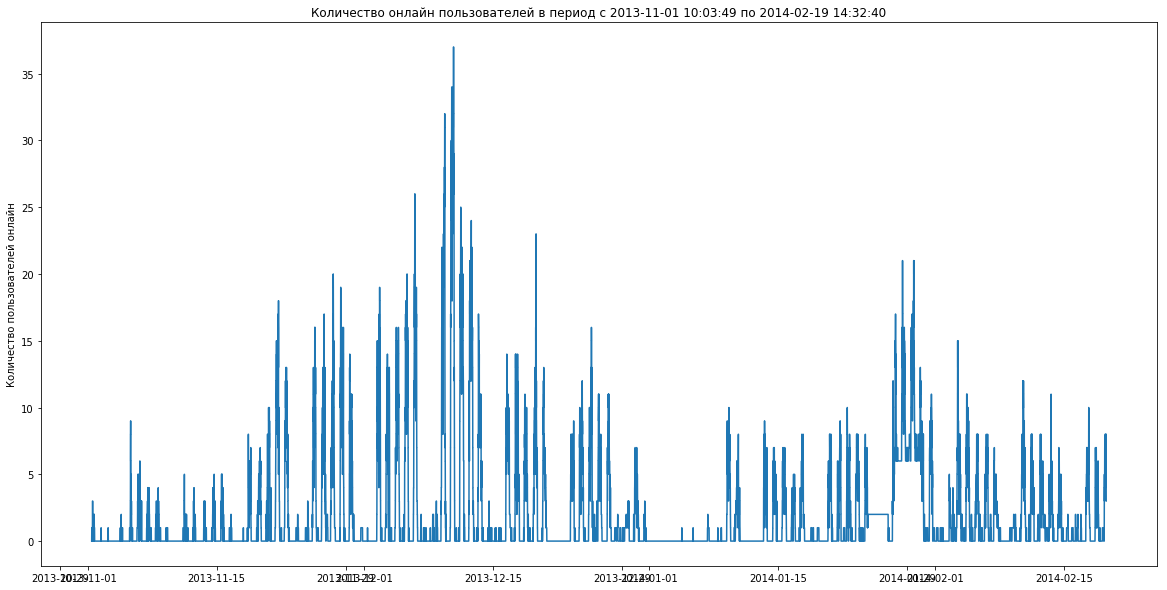

In [92]:
plt.figure(figsize=(20,10))
plt.plot(timestep, ans)
plt.title(f'Количество онлайн пользователей в период с {dt_min} по {dt_max}')
plt.plot()
plt.ylabel('Количество пользователей онлайн')
plt.show();

#### Доработки TODO
Данный алгоритм считает количество одновременных сессий а не уникальных пользователей, так как один пользователь возможно имеет в системе больше одной сессии одновременно 

### Задание 2. Классифицировать выборку данных на три класса 1,2,3 путем машинного обучения.
показать код и прокомментировать ход решения, а так же указать на проблемы с качеством решения этой задачи и варианты их решения.
исходные данные test2.zip

Колонки
class:  0 - не определен, 1,2,3 - размеченная выборка
material_id - технический атрибут, остальные признаки

### Решение
Загрузим датасет из файла

In [4]:
df = pd.read_csv('final 2.0.csv', sep=';', encoding="ISO-8859-1")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Подготовка датасета
Оценим датасет

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66238 entries, 0 to 0
Data columns (total 12 columns):
class           66237 non-null float64
material_id     66237 non-null float64
rating          66237 non-null float64
raters          66237 non-null float64
starts          66237 non-null float64
starters        66237 non-null float64
avg_duration    66237 non-null object
dispersion      66237 non-null float64
homeworks       66237 non-null float64
hw_makers       2417 non-null float64
count           0 non-null float64
Unnamed: 11     0 non-null float64
dtypes: float64(11), object(1)
memory usage: 6.6+ MB


In [6]:
df.head(5)

,class,material_id,rating,raters,starts,starters,avg_duration,dispersion,homeworks,hw_makers,count,Unnamed: 11
0,19.0,3.111111,9.0,5616.0,119.0,1407.940836,20.1490246234727,0.0,0.0,NaN,NaN,NaN
0,21.0,3.666667,9.0,2808.0,70.0,511.284450,6.0285037233842,0.0,0.0,NaN,NaN,NaN
0,112.0,4.724832,149.0,1340404.0,1306.0,1296.418769,270.91688796339,0.0,0.0,3.0,NaN,NaN
0,181.0,3.500000,8.0,1008.0,90.0,1007.419806,10.7517440445725,0.0,0.0,NaN,NaN,NaN
0,182.0,3.200000,5.0,1040.0,142.0,1954.539420,12.3013797462712,0.0,0.0,NaN,NaN,NaN


Похоже, что имена полей сдвинуты. Исправим это.

In [7]:
df.columns

Index(['class', 'material_id', 'rating', 'raters', 'starts', 'starters',
       'avg_duration', 'dispersion', 'homeworks', 'hw_makers', 'count',
       'Unnamed: 11'],
      dtype='object')

In [8]:
# Сдвигаем имена признаков
df.rename(columns=dict(zip(df.columns, df.columns[1:])), inplace=True)

# Создаем поле class из индекса
df['class'] = df.index
df.reset_index(inplace=True, drop=True)

Еще раз оценим получившийся датафрейм

In [9]:
df.sample(n=5)

,material_id,rating,raters,starts,starters,avg_duration,dispersion,homeworks,hw_makers,count,Unnamed: 11,Unnamed: 11,class
32626,64838.0,4.872727,109.0,38830.0,115.0,640.582266,60.3112218269607,0.0,0.0,NaN,NaN,NaN,0
27815,56990.0,2.500000,2.0,132.0,52.0,2286.871726,4.49786274032114,0.0,0.0,NaN,NaN,NaN,0
37358,72102.0,5.000000,1.0,476.0,359.0,2591.970614,15.1943766170233,0.0,0.0,NaN,NaN,NaN,0
12631,28903.0,4.937500,16.0,14128.0,313.0,785.856927,168.783828700118,0.0,0.0,1.0,NaN,NaN,0
46009,85703.0,4.400000,5.0,355.0,38.0,1380.743590,12.1795773844234,0.0,0.0,NaN,NaN,NaN,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66238 entries, 0 to 66237
Data columns (total 13 columns):
material_id     66237 non-null float64
rating          66237 non-null float64
raters          66237 non-null float64
starts          66237 non-null float64
starters        66237 non-null float64
avg_duration    66237 non-null float64
dispersion      66237 non-null object
homeworks       66237 non-null float64
hw_makers       66237 non-null float64
count           2417 non-null float64
Unnamed: 11     0 non-null float64
Unnamed: 11     0 non-null float64
class           66238 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 6.6+ MB


Признаки `count`, `Unnamed: 11`, `Unnamed: 11` выкинем, так как они не пустые. Также, удалим  `material_id` так как это технический атрибут и признаком не является

In [11]:
df.drop(['material_id', 'count', 'Unnamed: 11', 'Unnamed: 11'], axis=1, inplace=True)

Также, удалим одно пустое поле

In [12]:
df.dropna(inplace=True)

Исследуем признак `dispersion`

In [13]:
error_vars = np.array([])
for i in df['dispersion']:
    try:
        float(i)
    except:
        print(i,end=" ")

01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 04.ìàé 01.ìàé 01.ìàé 06.àâã 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 05.ìàé 09.ôåâ 01.ìàé 16.àâã 01.ìàé 04.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 06.àâã 01.ìàé 01.ìàé 04.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 08.àïð 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 01.ìàé 

Некоторые поля признака записаны в неверном формате. Так как это крайне небольшая часть датасета, то уберем записи с некорректной кодировкой.

In [269]:
df['dispersion'] = pd.to_numeric(df['dispersion'], errors='coerce')
df.dropna(axis=0, inplace=True)

Проверим, что все признаки количествены

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66178 entries, 0 to 66236
Data columns (total 9 columns):
rating          66178 non-null float64
raters          66178 non-null float64
starts          66178 non-null float64
starters        66178 non-null float64
avg_duration    66178 non-null float64
dispersion      66178 non-null float64
homeworks       66178 non-null float64
hw_makers       66178 non-null float64
class           66178 non-null int64
dtypes: float64(8), int64(1)
memory usage: 5.0 MB


In [16]:
df.describe()

,rating,raters,starts,starters,avg_duration,dispersion,homeworks,hw_makers,class
count,66178.000000,66178.000000,6.617800e+04,66178.000000,66178.000000,66178.000000,66178.000000,66178.000000,66178.000000
mean,3.722226,4.606501,1.612287e+03,73.501436,2101.057032,18.261918,0.022500,0.016002,0.028182
std,1.878345,9.192697,2.622813e+04,149.539808,7825.961872,52.758845,0.255188,0.159049,0.236915
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.500000,1.000000,3.800000e+01,16.000000,319.710402,2.865649,0.000000,0.000000,0.000000
50%,4.722222,2.000000,1.280000e+02,38.000000,812.615613,7.208006,0.000000,0.000000,0.000000
75%,5.000000,5.000000,5.360000e+02,72.000000,1737.289545,17.624433,0.000000,0.000000,0.000000
max,5.000000,218.000000,5.787040e+06,3128.000000,525321.202052,5683.135743,12.000000,6.000000,3.000000


#### Разбиение датасета
Разобьем датасет на часть которая классифицированна и которая нет

In [21]:
df['class'].value_counts()

0    65181
2      702
1      212
3       83
Name: class, dtype: int64

In [307]:
df_target = df[df['class'] == 0]
df_known = df[df['class'] != 0]

In [308]:
df_target.shape[0], df_known.shape[0]

(65181, 997)

In [273]:
df_known.columns[:-1]

Index(['rating', 'raters', 'starts', 'starters', 'avg_duration', 'dispersion',
       'homeworks', 'hw_makers'],
      dtype='object')

In [274]:
quantiles = df_known.quantile(.95)
quantiles

rating             5.000000
raters            15.000000
starts          4844.400000
starters         223.400000
avg_duration    7392.467771
dispersion        59.637099
homeworks          0.000000
hw_makers          0.000000
class              3.000000
Name: 0.95, dtype: float64

In [206]:
def cut_up_2_sigma(data, field):
    data.loc[data[field] > quantiles[field], field] = quantiles[field]

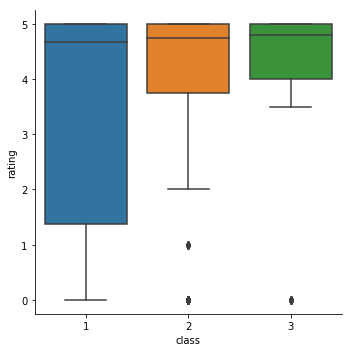

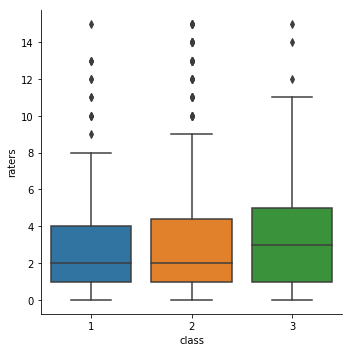

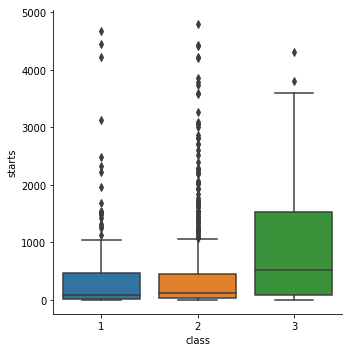

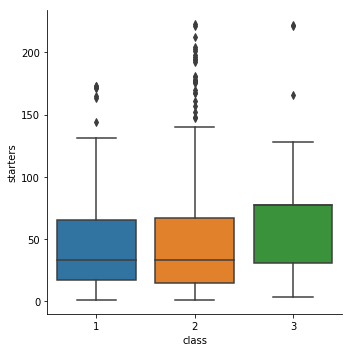

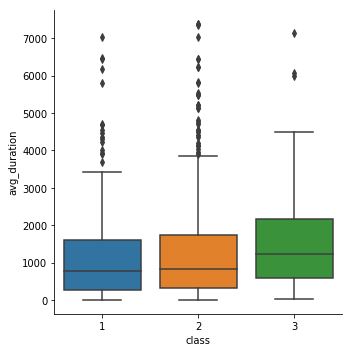

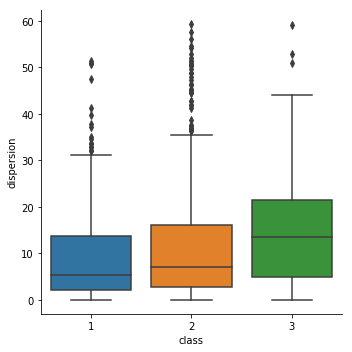

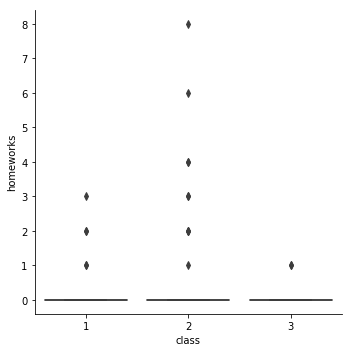

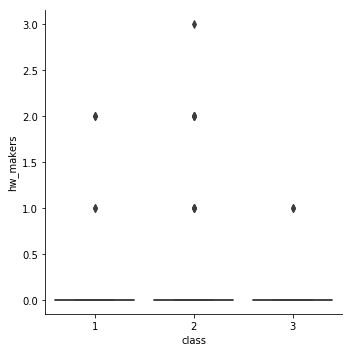

In [289]:
for col in df_known.columns[:-1]:
    sns.catplot(x="class", y=col, kind='box', data=df_known);

In [325]:
# Попробовать срезать выходящие за рамки значения
def drop_behind_borders(data, quant):
    quantiles = data.quantile(quant)
    for col in ['raters', 'starts', 'starters', 'avg_duration', 'dispersion']:
        data.drop(data[data[col] > quantiles[col]].index, inplace=True)
        
# Попробовать усреднить выходящие за рамки значения
def mean_behind_borders(data, quant):
    quantiles = data.quantile(quant)
    for col in ['raters', 'starts', 'starters', 'avg_duration', 'dispersion']:
        data.loc[data[col] > quantiles[col], col] = data[col].mean()
        
def do_nothing(data, quant):
    """Функция ничего не преобразует"""

#### Визуализация данных
Попробуем визуализировать данные. Для начала, проверим линейную зависимость признаков между друг другом

In [208]:
import seaborn as sns

In [305]:
# sns.pairplot(df_known)

На графиках не прослеживается линейная зависимость признаков друг от друга.
Давайте попробуем применить алгоритмы Случайного леса для кластеризации

In [310]:
# X = df_known.drop(['class'], axis=1)
# y = df_known['class']

# X.shape, y.shape

((997, 8), (997,))

In [279]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedShuffleSplit, LeaveOneOut
from sklearn.metrics import accuracy_score, auc, roc_curve
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#### Поиск наилучшего алгоритма решиляризации
В данном блоке я попробую ликвидировать выбросы датасетов, и посмотрю на результат

In [ ]:
xgbc = XGBClassifier(colsample_bytree=0.5, gamma=0.0, 
                             learning_rate=0.005, max_depth=7, 
                             min_child_weight=0.5, n_estimators=58,
                             reg_alpha=0.9, reg_lambda=0.99,
                             subsample=0.99,seed=42, silent=1, n_jobs=-1,
                             random_state=42)

for method in [drop_behind_borders, mean_behind_borders, do_nothing]:
    for quant in [.85, .9, .95, .99]:
        data = df_known.copy()
        method(data, quant)
#         X_train, X_test, y_train, y_test = train_test_split(data.drop(['class'], axis=1), 
#                                                             data['class'], 
#                                                             test_size=0.2, 
#                                                             random_state=42, 
#                                                             stratify=data['class'])
        
        
        parametrs = [{'n_estimators': [150,200,250,500,750,1000],
                      'max_features': ["auto", "sqrt", "log2"],
                      'max_depth': np.arange(10,25)}]
        
        clf = GridSearchCV(estimator=xgbc, 
                           param_grid=parametrs, n_jobs=-1, cv=sss)
        
        clf.fit(data.drop(['class'], axis=1), data['class'])
        
        print(clf.best_params_, clf.best_score_, '\n')
#         y_predicted = xgbc.fit(X_train, y_train).predict(X_test)
#         confusion_matrix = pd.crosstab(y_test, y_predicted, rownames=['Actual'], colnames=['Predicted'])
#         sns.heatmap(confusion_matrix, annot=True).set_title(f'{method.__name__} with {quant}')  
#         print(f'{method.__name__} with {quant}')
#         print(f'###\naccuracy_score: {accuracy_score(y_test, y_predicted):.3f} \n')
#         print(confusion_matrix, '\n')

In [280]:
sss = StratifiedShuffleSplit(n_splits=10, random_state=42)
loo = LeaveOneOut()
xgbc = XGBClassifier(colsample_bytree=0.5, gamma=0.0, 
                             learning_rate=0.005, max_depth=7, 
                             min_child_weight=0.5, n_estimators=58,
                             reg_alpha=0.9, reg_lambda=0.99,
                             subsample=0.99,seed=42, silent=1, n_jobs=-1,
                             random_state=42)

cross_val_score(xgbc, X, y, cv=sss).mean()



0.733

In [281]:
scores_mean = []
for i in range(1,30):
    sss = StratifiedShuffleSplit(n_splits=i, random_state=42)
    scores_mean.append(cross_val_score(xgbc, X, y, cv=sss).mean())
    xgbc.fit(X_train, y_train)

0.7357142857142858


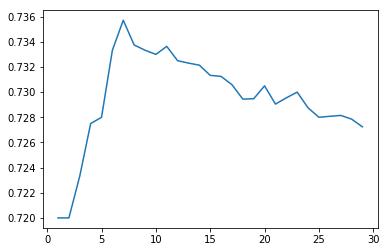

In [282]:
plt.plot(np.arange(1,30), scores_mean)
print(max(scores_mean))

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)

clrTree = DecisionTreeClassifier()
clrTree = clrTree.fit(X_train, y_train)
outTree = clrTree.predict(X_test)

clrKN = KNeighborsClassifier()
clrKN = clrKN.fit(X_train, y_train)
outKN = clrKN.predict(X_test)

# Prediction accuracy
print("Accuracy for Decision Tree Classifier: " + str(accuracy_score(y_test, outTree)*100)+"%")
print("Accuracy for KNeighbors Classifier: " + str(accuracy_score(y_test, outKN)*100)+"%") 

Accuracy for Decision Tree Classifier: 52.5%
Accuracy for KNeighbors Classifier: 63.0%


In [284]:
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.0, learning_rate=0.005,
       max_delta_step=0, max_depth=7, min_child_weight=0.5, missing=None,
       n_estimators=58, n_jobs=-1, nthread=None,
       objective='multi:softprob', random_state=42, reg_alpha=0.9,
       reg_lambda=0.99, scale_pos_weight=1, seed=42, silent=1,
       subsample=0.99)

In [285]:
y_predicted = xgbc.predict(X_test)

In [265]:
y_predicted

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2])

In [128]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)

ValueError: multiclass format is not supported

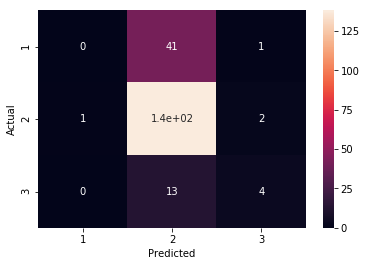

In [286]:
confusion_matrix = pd.crosstab(y_test, y_predicted, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [117]:
y_test.value_counts()

2    141
1     42
3     17
Name: class, dtype: int64

In [118]:
np.array(np.unique(y_predicted, return_counts=True)).T

array([[  2, 193],
       [  3,   7]])